In [1]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
# actions = ['come','away','spin']

actions = ['stop','grap','drop']

# actions = ['one', 'two', 'three', 'four', 'five']

data = np.concatenate([
    np.load('dataset/seq_stop_1721034353.npy'),
    np.load('dataset/seq_grap_1721034353.npy'),
    np.load('dataset/seq_drop_1721034353.npy')
], axis=0)

data.shape

FileNotFoundError: [Errno 2] No such file or directory: 'dataset/seq_come_1721032452.npy'

In [ ]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(1935, 30, 99)
(1935,)


In [ ]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(1935, 3)

In [ ]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(1741, 30, 99) (1741, 3)
(194, 30, 99) (194, 3)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='leaky_relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='leaky_relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

c:\Users\zfire\anaconda3\envs\test310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        41,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,163 (172.51 KB)

 Trainable params: 44,163 (172.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/model.keras', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.4667 - loss: 14.8793
Epoch 1: val_acc improved from -inf to 0.74227, saving model to models/model.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - acc: 0.4823 - loss: 13.9608 - val_acc: 0.7423 - val_loss: 1.4558 - learning_rate: 0.0010
Epoch 2/200
50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.8211 - loss: 0.9520
Epoch 2: val_acc improved from 0.74227 to 0.87113, saving model to models/model.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.8237 - loss: 0.9474 - val_acc: 0.8711 - val_loss: 0.5428 - learning_rate: 0.0010
Epoch 3/200
53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.8858 - loss: 1.5144
Epoch 3: val_acc did not improve from 0.87113
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.8828 - loss: 1.7005 - val_acc: 0.8093 - val_loss: 4.0034 - learning_rate: 0.0010
Epoch 4/200
52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.8125 - loss: 5.0935
Epoch 4: val_acc did not improve from 0.87113
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s

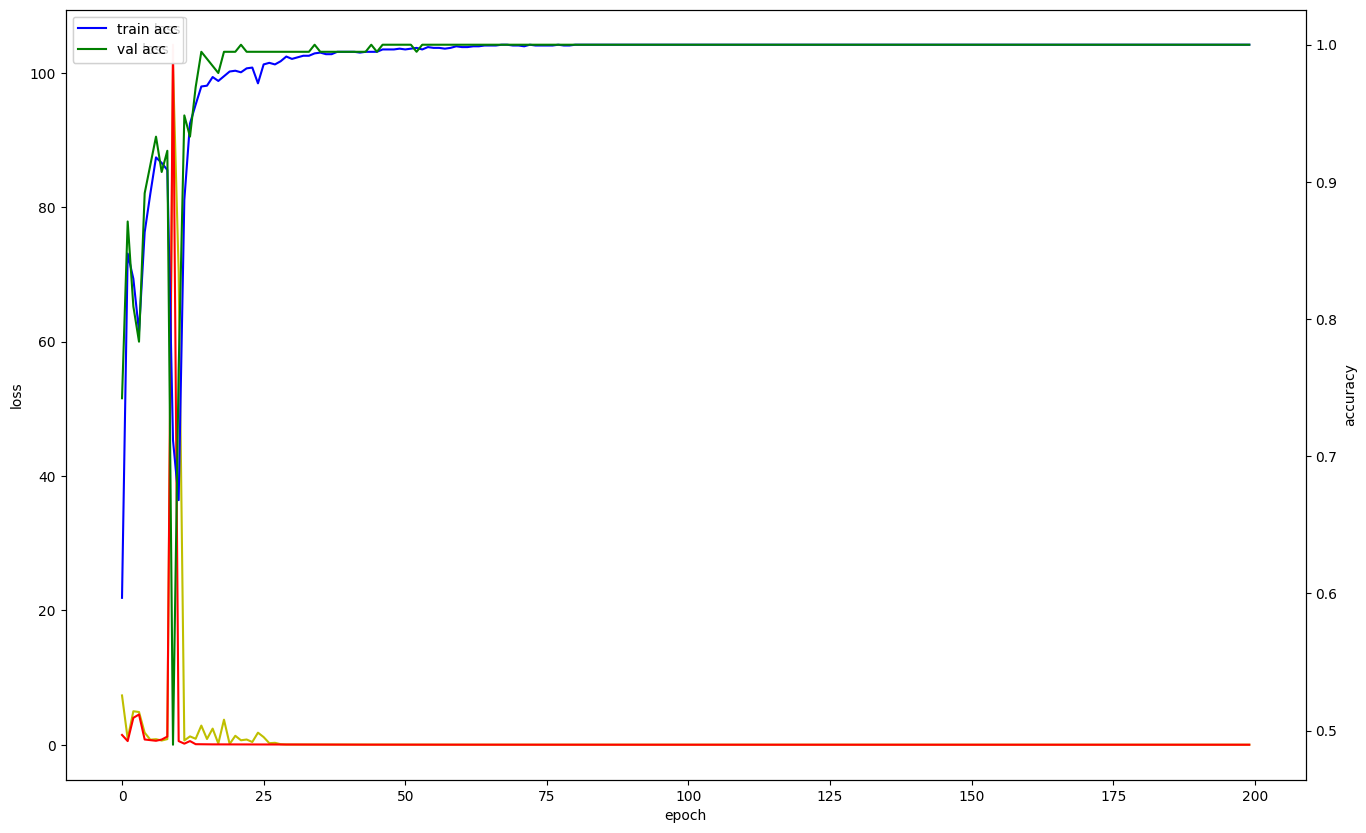

In [ ]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model.keras')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


array([[[132,   0],
        [  0,  62]],

       [[134,   0],
        [  0,  60]],

       [[122,   0],
        [  0,  72]]], dtype=int64)